In [1]:
using DrWatson

In [2]:
include(srcdir("rdpg.jl"))
using Main.rdpg
using StatsBase, Pipe, LightGraphs, DelimitedFiles, Random
using Plots, Ripserer, PersistenceDiagrams, PersistenceDiagramsBase
using Distances, LinearAlgebra, UMAP, SparseArrays

In [3]:
function read_graph(; path, delim='\t', labels=nothing)
    data = Int.(readdlm(path, delim))
    if labels !== nothing
        rownames = labels[:, 1]
        n = length(unique(data))
        indx = map(i -> findall(j -> j == i, rownames), data)
        A = sparse(indx[:, 1], indx[:, 2], Int(1), n, n)
    else
        tmp = unique(data)
        n = length(tmp)
        data .= minimum(tmp) != 1 ? data .+ 1 : data
        A = sparse(data[:, 1], data[:, 2], Int(1), n, n)
    end
    return A |> LightGraphs.LinAlg.symmetrize
end

read_graph (generic function with 1 method)

In [4]:
clean = true
path_to_graph = datadir("flights-edges.txt")
path_to_labels = datadir("flights-info.txt")

"/storage/work/s/suv87/julia/dp-rdpg/data/flights-info.txt"

In [5]:
labels = readdlm(path_to_labels, ',', header=false)
Adjacency = read_graph(path=path_to_graph, delim=',', labels=nothing);

In [6]:
if clean
    clean_indices = findall(i -> labels[i, 13] ∉ ["", "\\N"], eachindex(labels[:, 13]))
    Adjacency = Adjacency[clean_indices, clean_indices]
    labels = labels[clean_indices, :]
end

3254×16 Matrix{Any}:
    1  "AAE"   220  …  "airport"  "OurAirports"
    2  "AAL"   628     "airport"  "OurAirports"
    3  "AAN"  5937     "airport"  "OurAirports"
    4  "AAQ"  4353     "airport"  "OurAirports"
    5  "AAR"   607     "airport"  "OurAirports"
    6  "AAT"  6946  …  "airport"  "OurAirports"
    7  "AAX"  7395     "airport"  "OurAirports"
    8  "AAY"  3979     "airport"  "OurAirports"
    9  "ABA"  2955     "airport"  "OurAirports"
   10  "ABB"  9825     "airport"  "OurAirports"
   11  "ABD"  2097  …  "airport"  "OurAirports"
   12  "ABE"  4355     "airport"  "OurAirports"
   13  "ABI"  3718     "airport"  "OurAirports"
    ⋮               ⋱             ⋮
 3412  "ZRH"  1678     "airport"  "OurAirports"
 3413  "ZRJ"  5547     "airport"  "OurAirports"
 3414  "ZSA"  1956     "airport"  "OurAirports"
 3415  "ZSE"   917  …  "airport"  "OurAirports"
 3416  "ZSJ"  5548     "airport"  "OurAirports"
 3417  "ZTB"  5473     "airport"  "OurAirports"
 3418  "ZTH"  1488     "airport

Using the information associated with the vertices $\{v_1, v_2, \dots, v_n\}$, we create the composite variable $\{z_1, z_2, \dots, z_n\}$ given by

$$
z_i = \| (\text{lat}_i, \text{long}_i) \| \times \text{TimeZone}_i,
$$
where $\text{lat}_i, \text{long}_i$ are the latitude and longitude of the airport associated with vertex $v_i$, and $\text{TimeZone}_i$ is a decimal representation its time-zone w.r.t. UTC.

In [7]:
z_vals = ( norm.(eachrow(labels[:, 9:10])) .* labels[:, 12] ) |> normalize;

In [8]:
dim = 100
n = 20000
umap_params = (; n_neighbors=25, metric=Euclidean(), n_epochs=1000)

(n_neighbors = 25, metric = Euclidean(0.0), n_epochs = 1000)

In [9]:
A = copy(Adjacency)
N = size(A, 1)
rho = sum(A) / N^2

Xhat, _ = rdpg.spectralEmbed(A, d=dim, scale=false)
indx = eachindex(Xhat[:, 1])

Base.OneTo(3254)

In [10]:
Xnh = Xhat
embedding_umap_x = umap(Xnh', 2; umap_params...)';

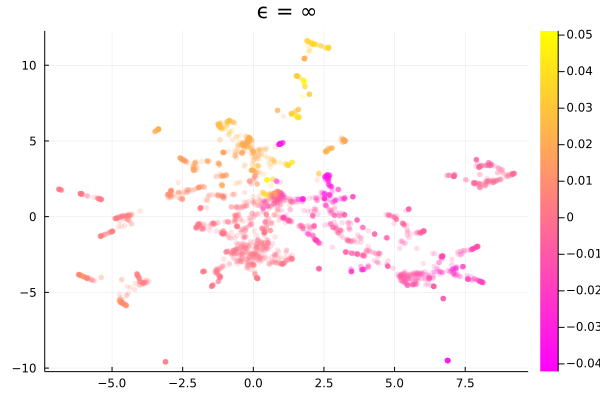

In [11]:
plt_umap_x = scatter(
    embedding_umap_x |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0, legend=:bottomleft, label=nothing, c=:spring, #lim=(-12, 12),
    marker_z=z_vals,
    title="ϵ = ∞"
)

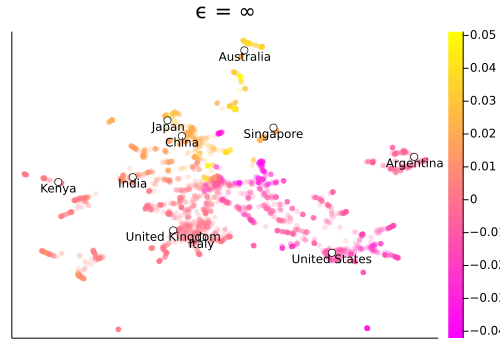

In [12]:
# noteworthy_airports = ["DCA", "SEA", "LGW", "FCO", "IST", "HFA", "DOH", "BLR", "SIN", "XIY", "NRT", "SYD", "BOB", "SCL" ,"AEP", "DUR", "NBO"]
noteworthy_airports = ["JFK", "FCO", "LGW", "SIN", "DEL", "XIY", "NRT", "SYD", "AEP", "NBO"]
airport_indices = findall(x -> x ∈ noteworthy_airports, labels[:, 2] )
plt_umap_x = Plots.scatter(
    plt_umap_x, size=(500,350),
    embedding_umap_x[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white, ticks=nothing,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, pointsize=8, color=:black)
)

----

In [13]:
Random.seed!(2022)
ϵ = 2 * log(N) / (sqrt(N) * rho)
B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
Ynh1, _ = rdpg.spectralEmbed(B, d=dim, scale=false);

In [14]:
embedding_umap_y1 = umap(Ynh1', 2; umap_params...)';

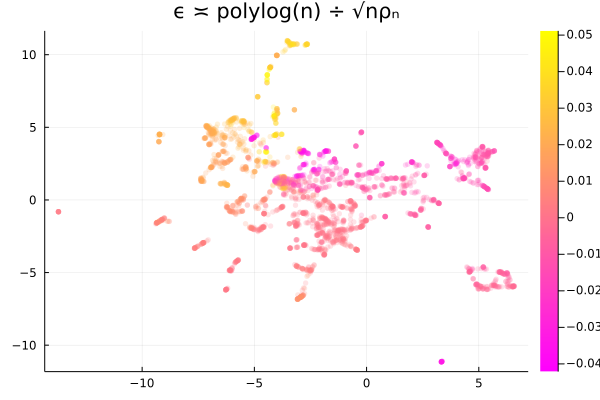

In [15]:
plt_umap_y1 = scatter(
    embedding_umap_y1 |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0.0, legend=:bottomleft, label=nothing, c=:spring, #lim=(-12, 12),
    marker_z=z_vals,
    # group=labels[:, 2],
    title="ϵ ≍ polylog(n) ÷ √nρₙ"
)

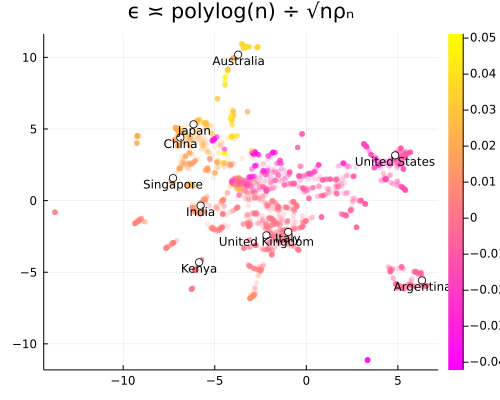

In [16]:
plt_umap_y1 = Plots.scatter(
    plt_umap_y1, size=(500, 400),
    embedding_umap_y1[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, "sans-serif", pointsize=8, color=:black)
)

----

In [17]:
Random.seed!(2022)
ϵ = 2 * log(N) / (N * rho)
B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)^2) ./ rdpg.σ(ϵ)^2
Ynh2, _ = rdpg.spectralEmbed(B, d=dim, scale=false);

In [18]:
embedding_umap_y2 = umap(Ynh2', 2; umap_params...)';

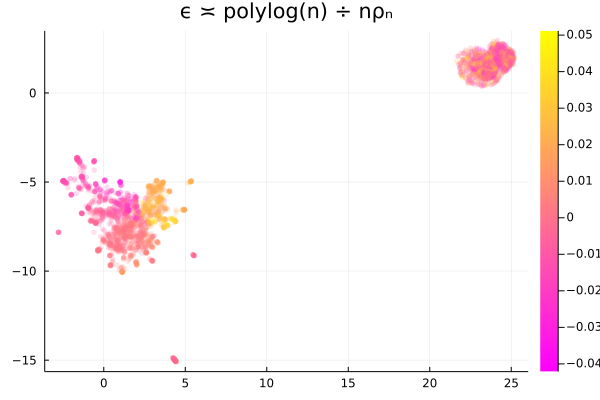

In [19]:
plt_umap_y2 = scatter(
    embedding_umap_y2 |> rdpg._Matrix_to_ArrayOfTuples,
    ma=0.2, ms=3, msw=0.00, legend=:bottomleft, label=nothing, c=:spring, #lim=(-12, 12),
    marker_z=z_vals,
    title="ϵ ≍ polylog(n) ÷ nρₙ"
)

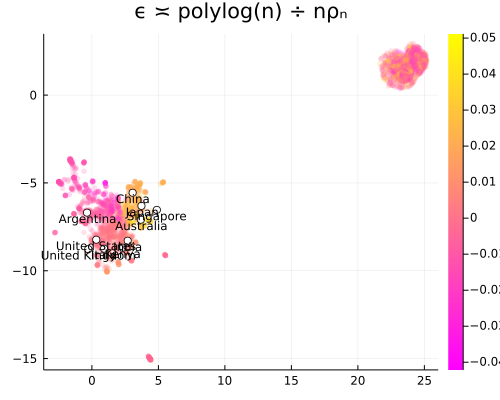

In [20]:
plt_umap_y2 = Plots.scatter(
    plt_umap_y2, size=(500, 400),
    embedding_umap_y2[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, "sans-serif", pointsize=8, color=:black)
)

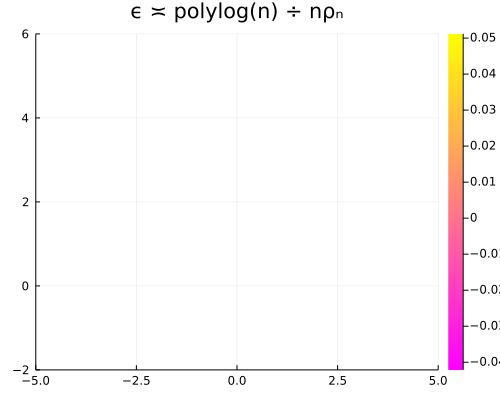

In [21]:
Plots.scatter(
    plt_umap_y2, size=(500, 400), xlim=(-5, 5), ylim=(-10, -2),
    embedding_umap_y2[airport_indices, :] |> rdpg._Matrix_to_ArrayOfTuples, label=nothing, c=:white,
    series_annotations = text.(labels[airport_indices, 6], valign=:top, halign=:center, "sans-serif", pointsize=8, color=:black)
)

In [22]:
# savefig(plt_umap_x, plotsdir("flights/plt_umap_x.pdf"))
# savefig(plt_umap_y1, plotsdir("flights/plt_umap_y1.pdf"))
# savefig(plt_umap_y2, plotsdir("flights/plt_umap_y2.pdf"))